In [1]:
import os
from typing import TypedDict, Annotated, Literal
from dotenv import load_dotenv
from langchain.agents import create_agent
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langgraph.graph import add_messages
from langgraph.graph import StateGraph, START, END
# from langchain_ollama import ChatOllama
from langchain_google_genai import ChatGoogleGenerativeAI
from pydantic import BaseModel, Field

In [2]:
gemini_api_key = os.getenv('GOOGLE_API_KEY')

In [3]:
class SummarizerState(TypedDict):
    input: str
    messages: Annotated[list[BaseMessage], add_messages]
    critique_score: int
    summary: str
    feedback: str
    threshold: int
    counter: int

In [4]:
model1 = ChatGoogleGenerativeAI(
    model='gemini-2.5-flash',
    api_key=gemini_api_key,
)
# model2 = ChatOllama(
#     model='deepseek-r1:1.5b',
#     temperature=0.4
# )

In [5]:
class Summary(BaseModel):
    summary: str = Field(description='Summarized text created by LLM')

In [6]:
summarizer_input_prompt = ChatPromptTemplate.from_template(
    """
You are a Summarizing Agent. You are given the following text:
{user_input}

Create a concise summary of this text.
Keep the length under 500 words.
"""
)

In [7]:
structured_summarizer_model = summarizer_input_prompt | model1.with_structured_output(Summary)

In [8]:
resummary_input_prompt = ChatPromptTemplate.from_template(
"""
Your are a Summary Rewriter. You are given the text: {user_input}, old summary: {summary} and feedback: {feedback} on the summary.
Rewrite the summary taking the feedback into consideration.
Keep the new summary under 500 words as well.

"""
)

In [9]:
resummary_structured_model = resummary_input_prompt | model1.with_structured_output(Summary)

In [10]:
class Critique(BaseModel):
    score: int = Field(description='Summary score out of 10')
    feedback: str =  Field(description='Feedback for the generated summary to make improvements')

In [11]:
critique_input_prompt = ChatPromptTemplate.from_template(
    """
You are a Summary Critique Agent. You review the provided summary: {summary} and review it.
Provie a score out of 10 based on 1.Conciseness 2.Depth 3.Accuracy
Also provide feedback on the summary for improvements.
Keep the feedback short and concise under 200 words.

"""
)

In [12]:
structured_critique_model = critique_input_prompt | model1.with_structured_output(Critique)

In [ ]:
def get_summary(state: SummarizerState):
    user_input = state['input']
    res = structured_summarizer_model.invoke(
    {
        'user_input': user_input,
    }
    )
    return {
        'messages': AIMessage(content=f'Generated Summary is: {res.summary}'),
        'summary' : res.summary
    }

def rewrite_summary(state: SummarizerState):
    
    summary = state['summary']
    feedback = state['feedback']
    user_input = state['input']

    res = resummary_structured_model.invoke(
        {
            'user_input': user_input,
            'summary': summary,
            'feedback': feedback
        }
    )

    return{
        'messages': AIMessage(content=f'Rewritten Summary is : {res.summary}'),
        'summary': res.summary
    }

def get_critique_score(state: SummarizerState):
    summary = state['summary']

    res = structured_critique_model.invoke(
        {
            'summary': summary,
        }
    )

    return {
        'messages': AIMessage(content=f'Critique Score : {str(res.score)} and feedback is {res.feedback}'),
        'critique_score': res.score,
        'counter': state['counter']+1,
        'feedback': res.feedback
    }

def does_summary_pass(state: SummarizerState)-> Literal['Pass', 'Fail']:

    score = state['critique_score']
    threshold  = state['threshold']
    counter = state['counter']

    if counter > 3:
        return 'Pass'
    else:
        if score >= threshold:
            return 'Pass'
        else:
            return 'Fail'


In [23]:
graph = StateGraph(SummarizerState)
graph.add_node('summarizer', get_summary)
graph.add_node('resummarizer', rewrite_summary)
graph.add_node('critique', get_critique_score)
graph.add_edge('summarizer', 'critique')
graph.add_edge(START, 'summarizer')
graph.add_edge('resummarizer', 'critique')
graph.add_conditional_edges('critique', does_summary_pass, {
    'Pass': END,
    'Fail':'resummarizer'
})

agent = graph.compile()

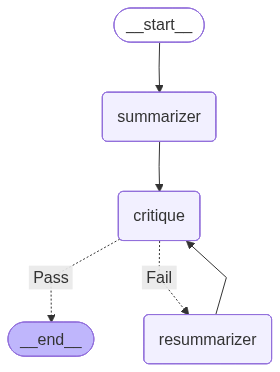

In [24]:
from IPython.display import Image
Image(agent.get_graph().draw_mermaid_png())

In [25]:
user_input = """
Artificial intelligence (AI) is the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, problem-solving, perception, and decision-making. It is a field of research in computer science that develops and studies methods and software that enable machines to perceive their environment and use learning and intelligence to take actions that maximize their chances of achieving defined goals.[1]

High-profile applications of AI include advanced web search engines (e.g., Google Search); recommendation systems (used by YouTube, Amazon, and Netflix); virtual assistants (e.g., Google Assistant, Siri, and Alexa); autonomous vehicles (e.g., Waymo); generative and creative tools (e.g., language models and AI art); and superhuman play and analysis in strategy games (e.g., chess and Go). However, many AI applications are not perceived as AI: "A lot of cutting edge AI has filtered into general applications, often without being called AI because once something becomes useful enough and common enough it's not labeled AI anymore."[2][3]

Various subfields of AI research are centered around particular goals and the use of particular tools. The traditional goals of AI research include learning, reasoning, knowledge representation, planning, natural language processing, perception, and support for robotics.[a] To reach these goals, AI researchers have adapted and integrated a wide range of techniques, including search and mathematical optimization, formal logic, artificial neural networks, and methods based on statistics, operations research, and economics.[b] AI also draws upon psychology, linguistics, philosophy, neuroscience, and other fields.[4] Some companies, such as OpenAI, Google DeepMind and Meta,[5] aim to create artificial general intelligence (AGI)—AI that can complete virtually any cognitive task at least as well as a human.

Artificial intelligence was founded as an academic discipline in 1956,[6] and the field went through multiple cycles of optimism throughout its history,[7][8] followed by periods of disappointment and loss of funding, known as AI winters.[9][10] Funding and interest vastly increased after 2012 when graphics processing units started being used to accelerate neural networks and deep learning outperformed previous AI techniques.[11] This growth accelerated further after 2017 with the transformer architecture.[12] In the 2020s, an ongoing period of rapid progress in advanced generative AI became known as the AI boom. Generative AI's ability to create and modify content has led to several unintended consequences and harms, which has raised ethical concerns about AI's long-term effects and potential existential risks, prompting discussions about regulatory policies to ensure the safety and benefits of the technology.



"""

In [26]:
res = agent.invoke({
    'messages': HumanMessage(content=user_input),
    'input': user_input,
    'counter': 0,
    'threshold': 9
})

In [27]:
for msg in res['messages']:
    msg.pretty_print()

================================ Human Message =================================


Artificial intelligence (AI) is the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, problem-solving, perception, and decision-making. It is a field of research in computer science that develops and studies methods and software that enable machines to perceive their environment and use learning and intelligence to take actions that maximize their chances of achieving defined goals.[1]

High-profile applications of AI include advanced web search engines (e.g., Google Search); recommendation systems (used by YouTube, Amazon, and Netflix); virtual assistants (e.g., Google Assistant, Siri, and Alexa); autonomous vehicles (e.g., Waymo); generative and creative tools (e.g., language models and AI art); and superhuman play and analysis in strategy games (e.g., chess and Go). However, many AI applications are not perceived as AI: "A l

In [19]:
res['summary']

'Artificial intelligence (AI) is the capacity of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, and problem-solving. It is a computer science field focused on developing methods and software that enable machines to perceive their environment and act intelligently to achieve goals. Prominent AI applications include advanced web search engines, recommendation systems, virtual assistants, autonomous vehicles, generative AI tools, and superhuman performance in strategy games. Many everyday applications of AI are not explicitly labeled as such once they become common. AI research encompasses various goals like learning, reasoning, knowledge representation, natural language processing, and perception, utilizing techniques such as search, mathematical optimization, neural networks, and statistical methods. AI also draws insights from psychology, linguistics, philosophy, and neuroscience. Companies like OpenAI and Google DeepMi